## Naver sentiment movie corpus v1.0
https://github.com/e9t/nsmc/

오늘은 KoNLPy, nltk, Keras를 이용해서 한국어 영화 리뷰의 감정을 분석하는 방법을 알아보겠습니다.

이진 분류 문제 중에서 대표적인 Keras에서 제공하는 imdb 데이터를 이용해서 긍정 부정을 예측하는 문제(링크)와 거의 같은 과정을 거쳐 진행이 됩니다.

이 포스트에서 사용한 코드는 (여기) 에서도 확인할 수 있습니다.

이 데이터셋은 네이버 영화의 리뷰 중 영화당 100개의 리뷰를 모아 총 200,000개의 리뷰(train: 15만, test: 5만)로 이루어져있고, 1~10점까지의 평점 중에서 중립적인 평점(5~8점)은 제외하고 1~4점을 긍정으로, 9~10점을 부정으로 동일한 비율로 데이터에 포함시켰습니다.

데이터는 id, document, label 세 개의 열로 이루어져있습니다. id는 리뷰의 고유한 key 값이고, document는 리뷰의 내용, label은 긍정(0)인지 부정(1)인지를 나타냅니다. txt로 저장된 데이터를 처리하기 알맞게 list 형식으로 받아서 사용하겠습니다.

In [1]:
!pwd

/mnt/d/00.git/notebooks/nlp-lab


In [1]:
!cat data/naver_movie/ratings_train.txt | head -n 10

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1
cat: write error: Broken pipe


In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # 파일 해더 제외
        data = data[1:]
    return data

train_data = read_data('data/naver_movie/ratings_train.txt')
test_data = read_data('data/naver_movie/ratings_test.txt')

In [3]:
test_data[0]

['6270596', '굳 ㅋ', '1']

# 데이터 전처리

이제 데이터를 학습하기에 알맞게 처리를 해볼텐데요, KoNLPy 라이브러리를 이용해서 형태소 분석 및 품사 태깅을 하겠습니다.

imdb 리뷰 분석 예제처럼 주어진 단어의 빈도만을 사용해서 처리해도 되지만 한국어는 영어와는 달리 띄어쓰기로 의미를 구분짓기에는 한계가 있고,

네이버 영화 데이터에는 맞춤법이나 띄어쓰기가 제대로 되어있지 않은 경우가 있기 때문에 정확한 분류를 위해서 KoNLPy를 이용하겠습니다.

KoNLPy는 띄어쓰기 알고리즘과 정규화를 이용해서 맞춤법이 틀린 문장도 어느 정도 고쳐주면서 형태소 분석과 품사를 태깅해주는 여러 클래스를 제공합니다. (링크 참조)

그 중에서 Okt(Open Korean Text) 클래스를 이용하겠습니다.

먼저 Okt를 이용해서 간단한 문장을 분석해보겠습니다.

In [4]:
from konlpy.tag import Okt

In [5]:
okt = Okt()
# 형태소를 분석하여 품사를 태깅
print(okt.pos(u'이 밤 그날으 ㅣ반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('으', 'Adverb'), ('ㅣ', 'KoreanParticle'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]


이제 아까 불러온 데이터에 형태소 분석을 통해서 품사를 태깅해주는 작업을 하겠습니다.

데이터의 양이 큰 만큼 시간이 오래 걸리기 때문에 이 작업을 반복하지 않도록 한 번 태깅을 마친 후에는 json 파일로 저장하는 것을 추천합니다.

여기에서는 이미 태깅이 완료된 train_docs.json 파일이 존재하면 반복하지 않도록 만들었습니다.

In [6]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm : 정규화, stem : 근어로 표시하기
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('data/naver_movie/train_docs.json'):
    with open('data/naver_movie/train_docs.json') as f:
        train_docs = json.load(f)
    with open('data/naver_movie/test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    
    #json 파일 저장
    with open('data/naver_movie/train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('data/naver_movie/test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")
        

In [7]:
# print를 깔끔하게...pprint        
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


분석한 데이터의 토큰(문자열을 분석을 위한 작은 단위)의 갯수를 확인해봅시다.

In [8]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


이제 이 데이터를 nltk 라이브러리를 통해서 전처리를 해볼텐데요, Text 클래스는 문서를 편리하게 탐색할 수 있는 다양한 기능을 제공합니다.

여기에서는 vocab().most_common 메서드를 이용해서 데이터에서 가장 자주 사용되는 단어를 가져올 때 사용하겠습니다.

In [9]:
import nltk
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


자주 나오는 단어 50개를 matplotlib 라이브러리를 통해서 그래프로 나타내보겠습니다.

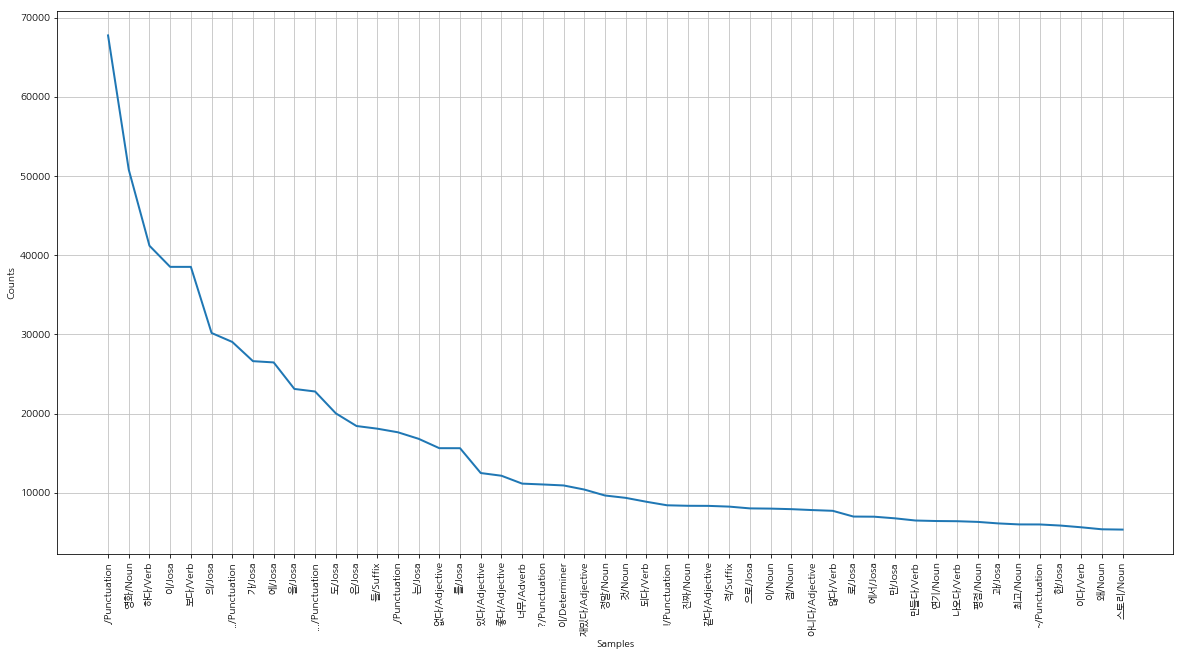

In [10]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

# font_fname = '/Library/Fonts/AppleGothic.ttf'
# font_name = font_manager.FontProperties(fname=font_fname).get_name()
# rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

이제 자주 사용되는 토큰 10000개를 사용해서 데이터를 벡터화를 시키겠습니다.

여기서는 원 핫 인코딩 대신에 CountVectorization을 사용했습니다.

이는 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW(Bag of Words) 인코딩한 벡터를 만드는 역할을 합니다.

In [12]:
text.vocab().most_common(1000)[1]

('영화/Noun', 50818)

In [14]:
# 시간이 꽤 걸립니다! 시간을 절약하고 싶으면 most_common의 매개변수를 줄여보세요.
selected_words = [f[0] for f in text.vocab().most_common(10000)]
#selected_words = [f[0] for f in text.vocab().most_common(10)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

이제 데이터를 float로 형 변환 시켜주면 데이터 전처리 과정은 끝납니다.

In [15]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

# 모델 정의 및 학습하기

IMDB 영화 리뷰 분석에서 사용했던 모델을 조금 변형했습니다.

모델의 구조는 다음의 그림과 같습니다.



두 개의 Dense 층은 64개의 유닛을 가지고 활성화 함수로는 relu를 사용했으며, 마지막 층은 sigmoid 활성화 함수를 사용해서 긍정의 리뷰일 확률을 출력합니다.

손실 함수로는 binary_crossentropy를 사용했고 RMSProp 옵티마이저를 통해서 경사하강법을 진행했습니다.

또한 배치 사이즈를 512로, 에포크를 10번으로 학습시켰습니다.

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()

# 위 text.vocab().most_common(10) 모양과 동일하게 해주여야 함
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
#model.add(layers.Dense(64, activation='relu', input_shape=(10,)))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
150000/150000 [==============================] - 7s 47us/sample - loss: 0.3857 - binary_accuracy: 0.8348
Epoch 2/10
150000/150000 [==============================] - 5s 31us/sample - loss: 0.3150 - binary_accuracy: 0.8657
Epoch 3/10
150000/150000 [==============================] - 5s 30us/sample - loss: 0.2904 - binary_accuracy: 0.8791
Epoch 4/10
150000/150000 [==============================] - 5s 31us/sample - loss: 0.2703 - binary_accuracy: 0.8902
Epoch 5/10
150000/150000 [==============================] - 5s 30us/sample - loss: 0.2509 - binary_accuracy: 0.8997
Epoch 6/10
150000/150000 [==============================] - 5s 30us/sample - loss: 0.2320 - binary_accuracy: 0.9081
Epoch 7/10
150000/150000 [==============================] - 4s 30us/sample - loss: 0.2129 - binary_accuracy: 0.9169
Epoch 8/10
150000/150000 [==============================] - 5s 30us/

# 성능 확인 

In [18]:
results

[0.41655599217414857, 0.85258]

# 새로운 데이터로 결과 예측하기

이제 문자열 형태의 새로운 데이터를 받아와서 바로 결과를 예측하는 함수를 만들어 보겠습니다.

데이터의 형태를 맞춰주기 위해서 np.expand_dims 메서드를 이용해 array의 축을 확장시켰습니다.

최종 확률이 0.5 보다 크면 긍정이고, 그렇지 않으면 부정이라고 예측했습니다.

In [19]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% --> 긍정\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% --> 부정\n".format(review, (1 - score) * 100))

이렇게 여러 가지 한글 리뷰를 매개변수로 넣어서 예측할 수 있습니다.

In [20]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 97.12% --> 긍정

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 98.37% --> 부정

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 96.66% --> 긍정

[믿고 보는 감독이지만 이번에는 아니네요]는 62.16% --> 부정

[주연배우 때문에 봤어요]는 89.04% --> 부정



In [28]:
predict_pos_neg("흠")

[흠]는 83.11% --> 부정

